### Импорт

In [1]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model # Linear Regression (OLS)
from sklearn import tree # Decision Tree
from sklearn import svm # Support Vector Machines (SVM)
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

df_metrics=pd.DataFrame() # Датафрейм для сбора метрик

### Функции

In [2]:
def delete_outliers (df, column_name): # Функция удаления выбросов из датафрейма методом IRQ
    '''
    Parameters
    ----------
    df: source DataFrame from which outliers are to be removed
    column_name: name of the column to be checked for outliers
    
    Return: Dataframe without outliers in column_name
    '''
    q1=df[column_name].quantile(0.25)
    q3=df[column_name].quantile(0.75)
    d=1.5*(q3-q1)
    lower_bound=q1-d
    upper_bound=q3+d
    print (f"Найдено и удалено {df[(df[column_name]<lower_bound)|(df[column_name]>upper_bound)].shape[0]} выброс(а/ов) в столбце {column_name}")
    return df[(df[column_name]>=lower_bound)&(df[column_name]<=upper_bound)] # включая концы

def model_metrics(test, pred, text): # Метрики качества модели регрессии
    r2=r2_score(test, pred)
    mae=mean_absolute_error(test, pred)
    rmse=np.sqrt(mean_squared_error(test, pred))
    mape=mean_absolute_percentage_error(test, pred)
    return pd.DataFrame([{'TEXT':text, 'R2':r2, 'MAE':mae, 'RMSE':rmse, 'MAPE':mape}])

def model_test(m, text, X_tr, y_tr, X_t, y_t): # Функция тестирования модели
    global df_metrics
    m.fit(X_tr, y_tr)
    y_pred = m.predict(X_t)
    plt.scatter(y_t, y_pred)
    plt.show()
    d = model_metrics(y_t, y_pred, text)
    if df_metrics.size!=0:
        df_metrics=pd.concat([df_metrics, d], axis=0)
    else:
        df_metrics=d
    print (f"Метрики:\n{d}\n")
    return y_pred

def split_selection(X_matrix, y): # Функция разбиения выборки в соответствии с заданием
    rs=32
    X_train, X_test, y_train, y_test=train_test_split(X_matrix, y, test_size=0.4, random_state=rs) # в test пока 40%
    X_test, X_forecast, y_test, y_forecast=train_test_split(X_test, y_test, test_size=0.5, random_state=rs) # делим тестовую выборку попалам
    return X_train, y_train, X_test, y_test, X_forecast, y_forecast

lambda_norm = lambda x: (x-x.min())/(x.max()-x.min()) # Функция для нормализации

### Загрузка данных и подготовка датафрейма

Документация - https://vincentarelbundock.github.io/Rdatasets/doc/AER/CollegeDistance.html

In [3]:
item = 'CollegeDistance' # Выбрать из поля Item для вашего датасета
package = 'AER' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data

#Проверка на дубликаты и их удаление в случае наличия
dups=df.duplicated().sum()
print (f"Найдено {dups} дубликатов")
if dups>0:
    df=df.drop_duplicates()
    print ("Произведено удаление дубликатов")

# Проверка на пропуски
n_miss=df.isna().sum().sum()
print (f"Найдено {n_miss} пропусков")
if n_miss>0: # Удаление пропусков
    df.dropna(inplace=True)
    print("Пропуски были удалены")

# Удаление выбросов из необходимых столбцов
df=delete_outliers(df, 'score')
df=delete_outliers(df, 'tuition')
df=delete_outliers(df, 'wage')

print (f"Размер датафрейма:\n{df.shape}\n")
print ("Подготовленный датафрейм:")
df.head()

Найдено 0 дубликатов
Найдено 0 пропусков
Найдено и удалено 0 выброс(а/ов) в столбце score
Найдено и удалено 0 выброс(а/ов) в столбце tuition
Найдено и удалено 272 выброс(а/ов) в столбце wage
Размер датафрейма:
(4467, 14)

Подготовленный датафрейм:


,gender,ethnicity,score,fcollege,mcollege,home,urban,unemp,wage,distance,tuition,education,income,region
rownames,,,,,,,,,,,,,,
1,male,other,39.150002,yes,no,yes,yes,6.2,8.09,0.2,0.88915,12,high,other
2,female,other,48.869999,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
3,male,other,48.740002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
4,male,afam,40.400002,no,no,yes,yes,6.2,8.09,0.2,0.88915,12,low,other
5,female,other,40.480000,no,no,no,yes,5.6,8.09,0.4,0.88915,13,low,other


### Решение

На основе разведочного анализа второй аттестации и выявленной зависимости между tuition и wage формулируем задачу регрессии:
спрогнозировать среднюю стоимость обучения в государственном колледже за 4 года на основе данных о средней часовой ставке штатаи других характеристик

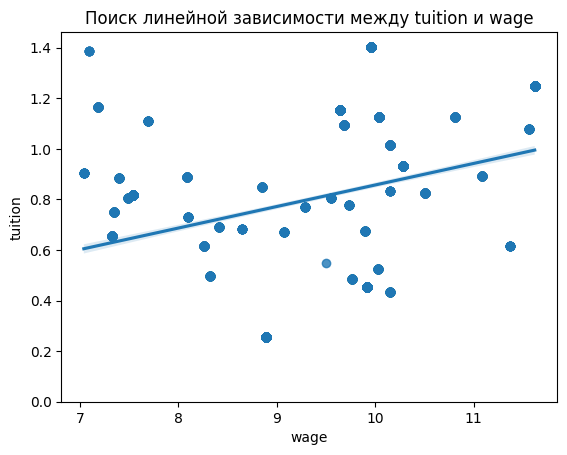

In [4]:
sns.regplot(x="wage", y="tuition", data=df)
plt.title("Поиск линейной зависимости между tuition и wage")
plt.ylim(0,)
plt.show()

Формирование матрицы X и вектора y

In [5]:
cat_vars=['gender', 'ethnicity', 'fcollege', 'mcollege', 'home', 'urban', 'income', 'region'] # категориальные переменные датасета
num_vars = ['score', 'unemp', 'wage', 'distance', 'education'] # числовые переменные
target_var = ['tuition'] #  целевая переменная
X_dummies = pd.get_dummies(df[cat_vars], drop_first = True, dtype = int) # кодиреуем 8 исходных категориальных переменных в 9 числовых
X = df[num_vars].merge(right = X_dummies, how = 'inner', left_index = True, right_index = True) # формируем матрицу X из числовых и перекодированных переменных
y = df[target_var] # формируем вектор y
X

,score,unemp,wage,distance,education,gender_male,ethnicity_hispanic,ethnicity_other,fcollege_yes,mcollege_yes,home_yes,urban_yes,income_low,region_west
rownames,,,,,,,,,,,,,,
1,39.150002,6.2,8.09,0.2,12,1,0,1,1,0,1,1,0,0
2,48.869999,6.2,8.09,0.2,12,0,0,1,0,0,1,1,1,0
3,48.740002,6.2,8.09,0.2,12,1,0,1,0,0,1,1,1,0
4,40.400002,6.2,8.09,0.2,12,1,0,0,0,0,1,1,1,0
5,40.480000,5.6,8.09,0.4,13,0,0,1,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9391,56.529999,6.6,8.89,0.8,13,1,0,0,0,0,1,0,0,1
9401,59.770000,6.6,8.89,0.8,15,1,0,0,0,0,1,0,0,1
9411,43.169998,6.6,8.89,0.8,12,1,0,1,0,0,1,0,0,1


Деление выборки на обучающую, тестовую и прогнозную

In [6]:
X0=X[['wage']] # Используем только столбец wage
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(X0, y)

Обучение моделей

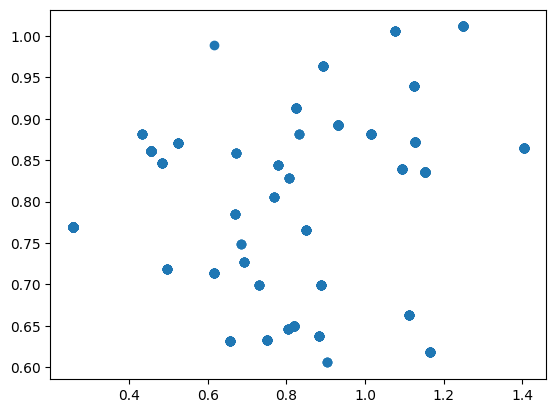

Метрики:
         TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage)  0.079988  0.277982  0.325701  0.552804



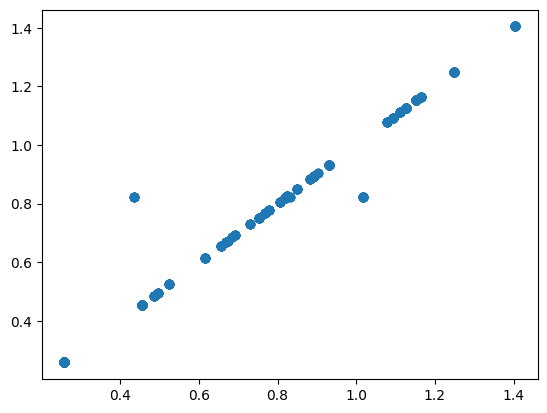

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


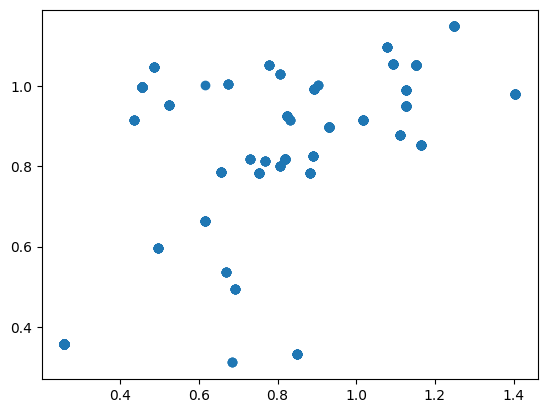

Метрики:
         TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage)  0.425503  0.185832  0.257375  0.321472



In [7]:
# Модель Linear Regression (OLS)
ols = linear_model.LinearRegression()
y_pred=model_test(ols, "OLS (wage)", X_train, y_train, X_test, y_test)

# Модель Decision Tree
regr_tree = tree.DecisionTreeRegressor()
y_pred=model_test(regr_tree, "Decision Tree (wage)", X_train, y_train, X_test, y_test)

# Модель Support Vector Machines (SVM)
regr_svm = svm.SVR()
y_pred=model_test(regr_svm, "SVM (wage)", X_train, y_train, X_test, y_test)

На основании метрик и графиков делаем вывод о том, что наилучшее качество предсказаний дает модель Decision Tree. Судя по метрикам, результат Decision Tree приемлем. Ниже попытаемся увеличить качество моделей

Оценим качество всех моделей при использовании всех переменных в матрице X

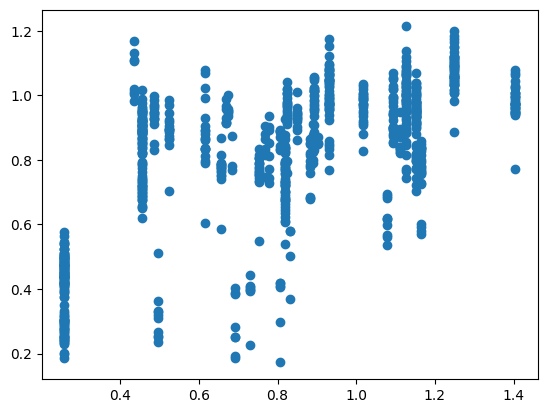

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  OLS (all vars)  0.429476  0.209219  0.256484  0.345588



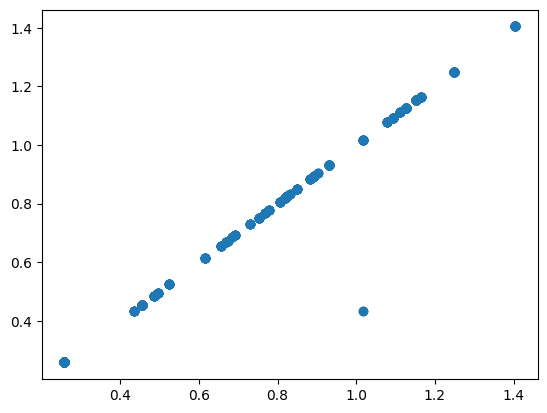

Метрики:
                       TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (all vars)  0.993421  0.001303  0.027543  0.001283



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


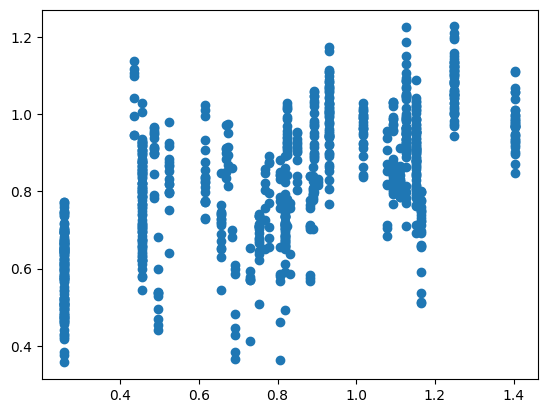

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  SVM (all vars)  0.380152  0.224538  0.267341  0.424048



In [8]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(X, y)
y_pred=model_test(ols, "OLS (all vars)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (all vars)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (all vars)", X_train, y_train, X_test, y_test)

При использовании всех переменных возрасло качество модели OLS, но лучшей моделью по-прежнему является модель Decision Tree

Произведем нормализацию и повторно оценим качество всех моделей

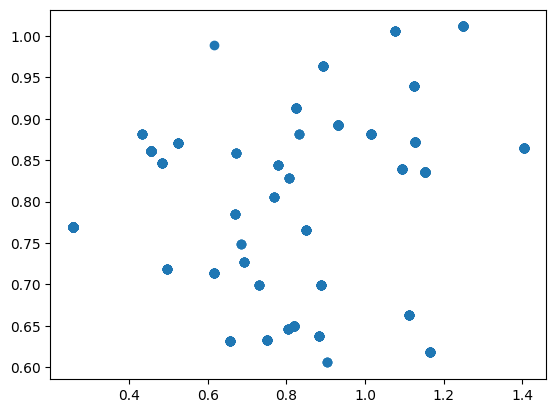

Метрики:
              TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage norm)  0.079988  0.277982  0.325701  0.552804



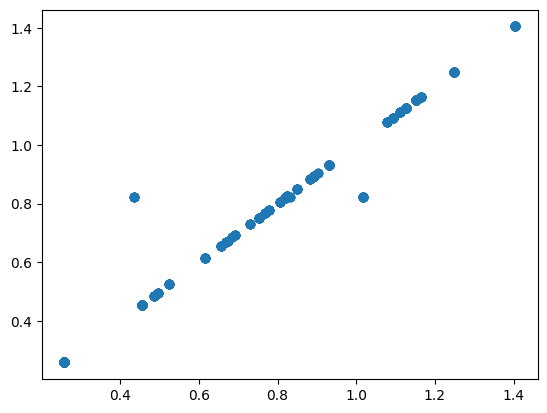

Метрики:
                        TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage norm)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


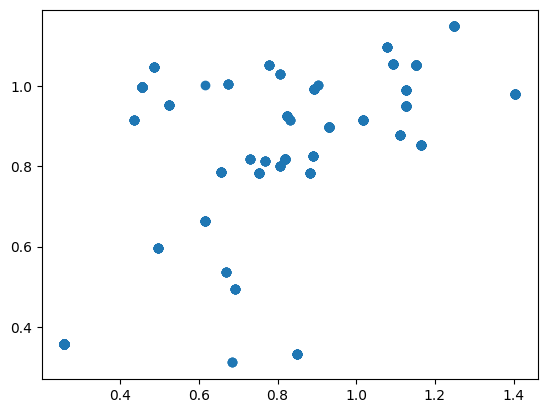

Метрики:
              TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage norm)  0.425503  0.185832  0.257375  0.321472



In [9]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(lambda_norm(X0), y)
y_pred=model_test(ols, "OLS (wage norm)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage norm)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage norm)", X_train, y_train, X_test, y_test)

Нормализация не увеличила качество первоначальных предсказаний моделей. Вероятно, нормализация предусмотрена в алгоритме самих моделей

Оценим качество всех моделей при возведении матрицы X0 в квадрат

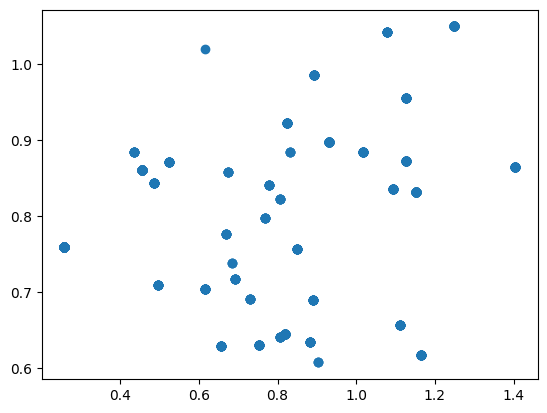

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage sqr)  0.097601  0.274748  0.322569  0.545682



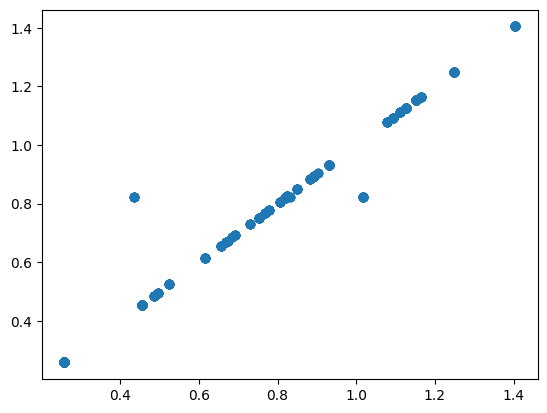

Метрики:
                       TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage sqr)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


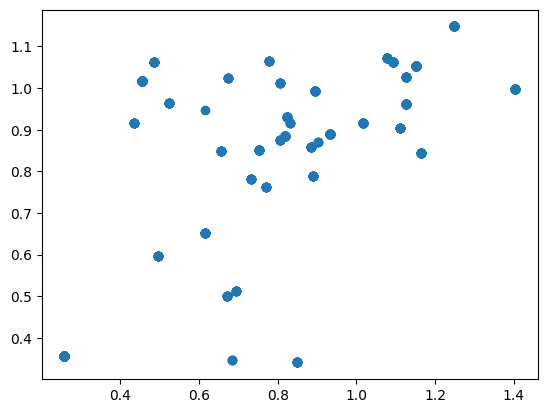

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage sqr)  0.403642  0.191995  0.262226  0.332805



In [10]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(np.square(X0), y)
y_pred=model_test(ols, "OLS (wage sqr)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage sqr)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage sqr)", X_train, y_train, X_test, y_test)

Качество моделей близко к первоначальному

Оценим качество всех моделей при взятии логарифма матрицы X0

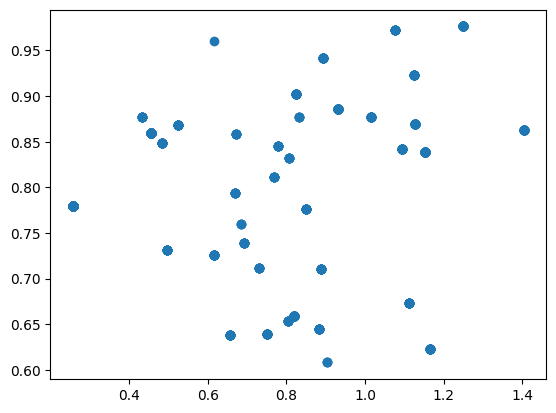

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage log)  0.062814  0.280603  0.328727  0.558845



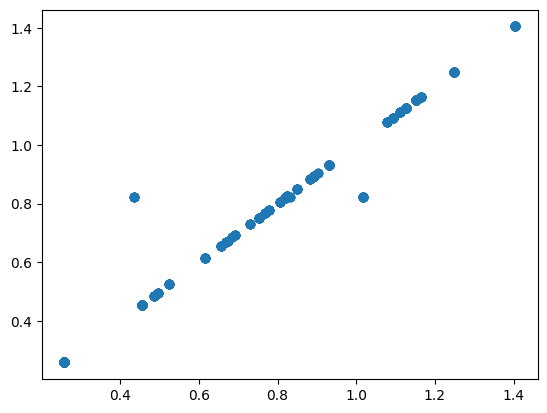

Метрики:
                       TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage log)  0.979906  0.008504  0.048134  0.012968



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


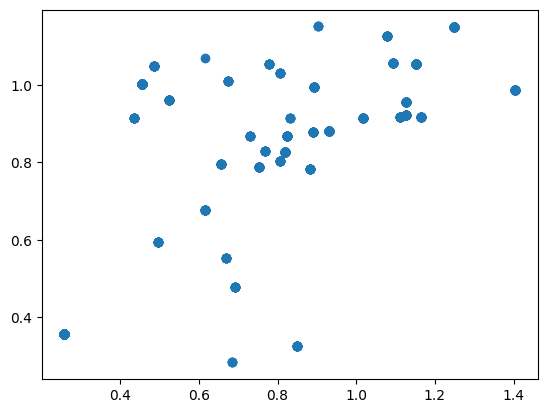

Метрики:
             TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage log)  0.422504  0.186874  0.258046  0.324246



In [11]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(np.log(X0), y)
y_pred=model_test(ols, "OLS (wage log)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage log)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage log)", X_train, y_train, X_test, y_test)

Качество моделей близко к первоначальному

Добавим в модель фактор нахождения в городской местности и повторно оценим качество всех моделей

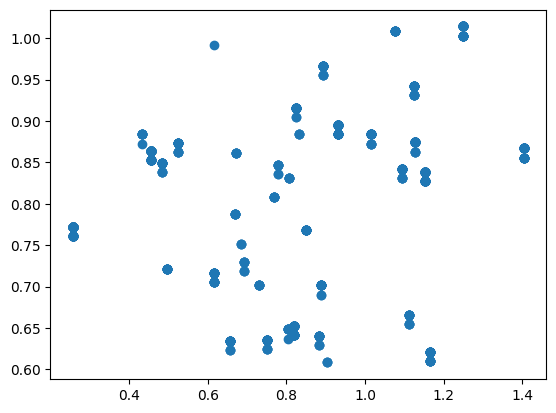

Метрики:
                    TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage, urban_yes)  0.079639  0.278049  0.325763  0.552594



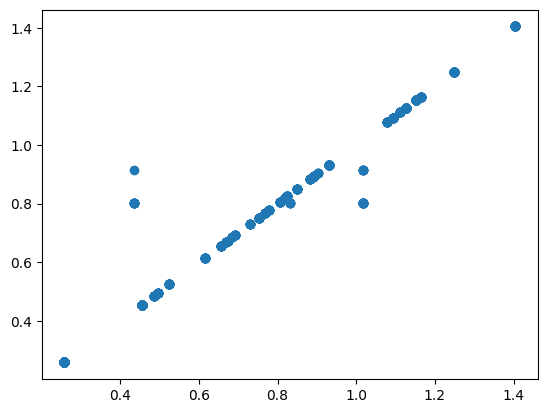

Метрики:
                              TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage, urban_yes)  0.979974  0.008458  0.048053  0.012854



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


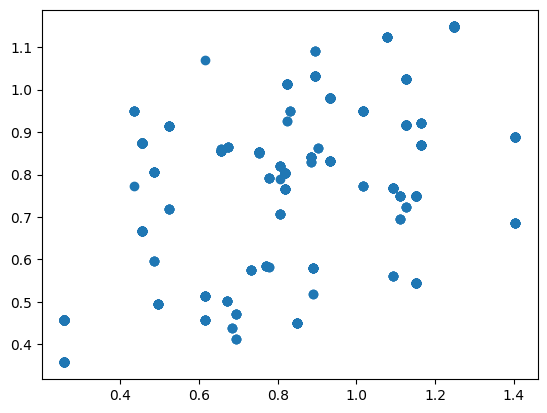

Метрики:
                    TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage, urban_yes)  0.320604  0.227453  0.279888  0.356937



In [12]:
X1=X[['wage', 'urban_yes']] # Используем столбцы wage и urban_yes
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(lambda_norm(X1), y)
y_pred=model_test(ols, "OLS (wage, urban_yes)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage, urban_yes)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage, urban_yes)", X_train, y_train, X_test, y_test)

Качество моделей OLS, Decision Tree практически без изменений, качество модели SVM упало

Добавим в модель расстояние и повторно оценим качество всех моделей

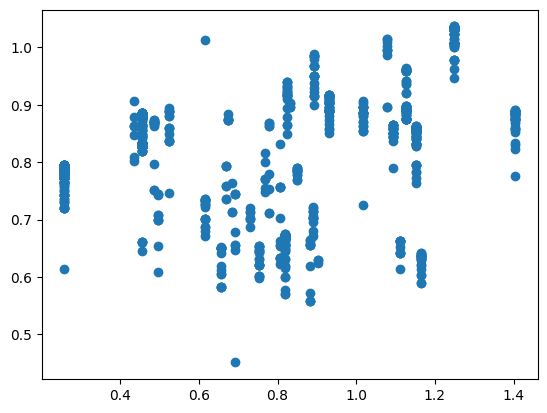

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  OLS (wage, distance)  0.090941  0.274195  0.323757  0.549467



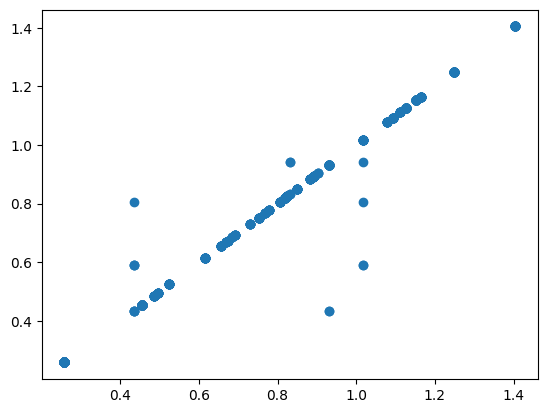

Метрики:
                             TEXT       R2       MAE      RMSE      MAPE
0  Decision Tree (wage, distance)  0.98889  0.003575  0.035791  0.004906



C:\Anaconda\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


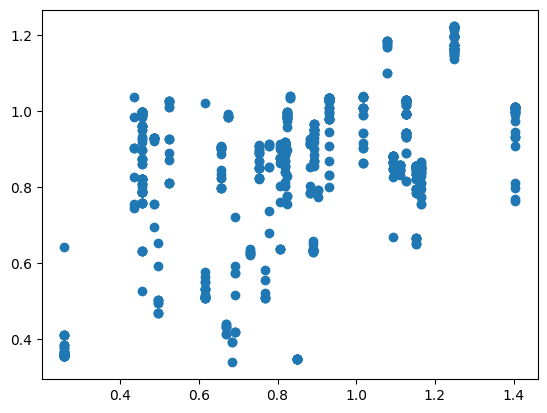

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  SVM (wage, distance)  0.422658  0.206505  0.258012  0.328027



In [13]:
X1=X[['wage', 'distance']] # Используем столбцы wage и distance
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(lambda_norm(X1), y)
y_pred=model_test(ols, "OLS (wage, distance)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_tree, "Decision Tree (wage, distance)", X_train, y_train, X_test, y_test)
y_pred=model_test(regr_svm, "SVM (wage, distance)", X_train, y_train, X_test, y_test)

Качество моделей близко к первоначальному

In [14]:
print (f"Итоговая таблица с метриками:\n {df_metrics.reset_index(drop=True)}")

Итоговая таблица с метриками:
                                TEXT        R2       MAE      RMSE      MAPE
0                        OLS (wage)  0.079988  0.277982  0.325701  0.552804
1              Decision Tree (wage)  0.979906  0.008504  0.048134  0.012968
2                        SVM (wage)  0.425503  0.185832  0.257375  0.321472
3                    OLS (all vars)  0.429476  0.209219  0.256484  0.345588
4          Decision Tree (all vars)  0.993421  0.001303  0.027543  0.001283
5                    SVM (all vars)  0.380152  0.224538  0.267341  0.424048
6                   OLS (wage norm)  0.079988  0.277982  0.325701  0.552804
7         Decision Tree (wage norm)  0.979906  0.008504  0.048134  0.012968
8                   SVM (wage norm)  0.425503  0.185832  0.257375  0.321472
9                    OLS (wage sqr)  0.097601  0.274748  0.322569  0.545682
10         Decision Tree (wage sqr)  0.979906  0.008504  0.048134  0.012968
11                   SVM (wage sqr)  0.403642  0.191995  

На основании выведенной статистики в качестве наилучшей модели примем модель Decision Tree для переменной wage, так как она с одной стороны обладает одинм из больших значением R2, а также почти самыми малыми значениями MAE, RMSE, MAPE, а с другой стороны проста в обосновании взаимосвязей.

Сделаем предсказание на основе оставшихся 20% выборки

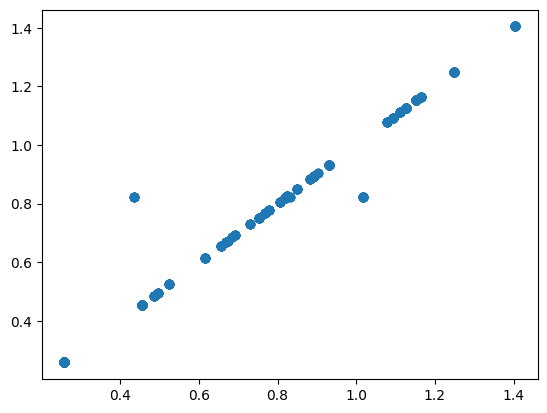

Метрики:
                   TEXT        R2       MAE      RMSE      MAPE
0  Decision Tree (wage)  0.979906  0.008504  0.048134  0.012968



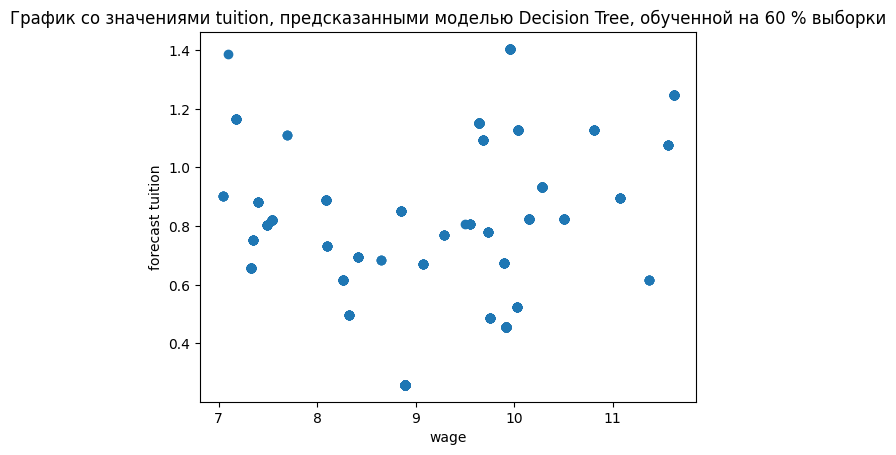

In [15]:
X_train, y_train, X_test, y_test, X_forecast, y_forecast = split_selection(X0, y)
y_pred=model_test(regr_tree, "Decision Tree (wage)", X_train, y_train, X_test, y_test)
y_pred=regr_tree.predict(X_forecast)
plt.scatter(X_forecast, y_pred)
plt.title ("График со значениями tuition, предсказанными моделью Decision Tree, обученной на 60 % выборки")
plt.xlabel("wage")
plt.ylabel("forecast tuition")
plt.show()